In [2]:
import anndata as ad
import decoupler as dc
import pandas as pd
import numpy as np
import scanpy as sc

In [3]:
sc_counts = ad.read_h5ad("../data/sc_counts_filtered.h5ad")

In [3]:
pbmc_markers = pd.read_csv("../data/decoupler_final_labels.csv")

In [149]:
def run_dc(adata, labels, resolution, meta_name):
    adata = adata.copy()
    ## Run ORA:
    dc.run_ora(
    mat=adata,
    net=labels,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
    )
    
    acts = dc.get_acts(adata, obsm_key='ora_estimate')
    # We need to remove inf and set them to the maximum value observed
    acts_v = acts.X.ravel()
    max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
    acts.X[~np.isfinite(acts.X)] = max_e

    sc.pp.scale(acts)
    df = dc.rank_sources_groups(acts, groupby='leiden_'+str(resolution), reference='rest', method='wilcoxon')
    
    annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
    adata.obs[str(meta_name)] = [annotation_dict[clust] for clust in adata.obs['leiden_'+str(resolution)]]
    
    adata.obs[str(meta_name)] = adata.obs[str(meta_name)].apply(lambda x: 'T cells' if  x.startswith("T ") else x)    
    return adata

In [5]:
# plot umap of anndata with raw data

In [7]:
sc_counts.raw = sc_counts.copy()

In [8]:
sc.pp.normalize_total(sc_counts, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(sc_counts)

In [9]:
sc.pp.highly_variable_genes(sc_counts, n_top_genes=2000)
adata_hvg = sc_counts[:, sc_counts.var.highly_variable].copy()

In [10]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [11]:
sc_counts.obsm['X_umap'] = adata_hvg.obsm['X_umap']

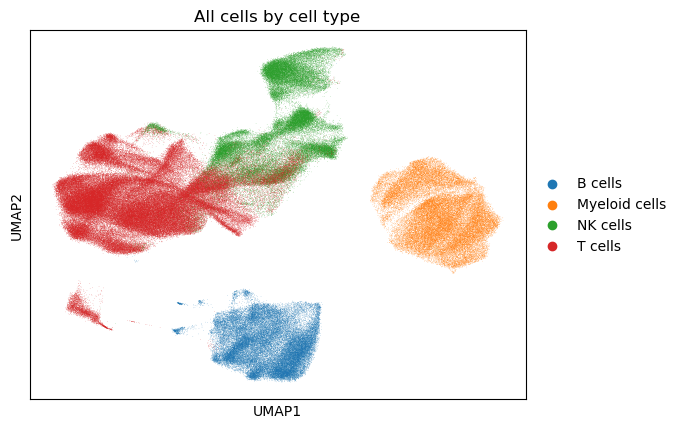

In [31]:
# plot umap of sc_counts
sc.pl.umap(sc_counts, color='cell_type', title="All cells by cell type")

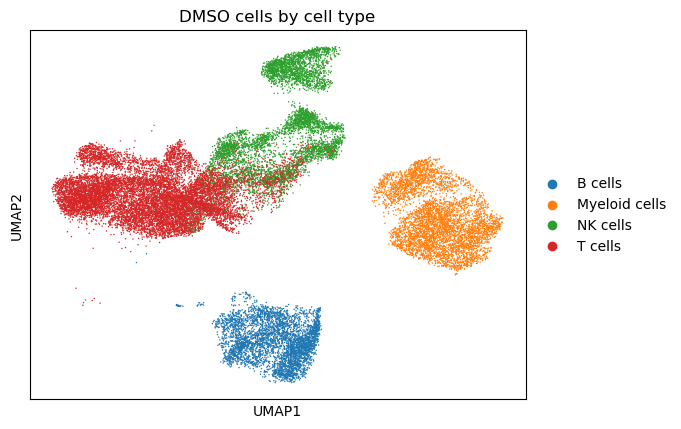

In [32]:
sc.pl.umap(sc_counts[(sc_counts.obs.sm_name == "Dimethyl Sulfoxide")], color='cell_type', title="DMSO cells by cell type")

In [45]:
del sc_counts.uns["sm_name_colors"]

/Users/arturszalata/miniconda3/envs/open-problems-23-sc-perturbation-prediction/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


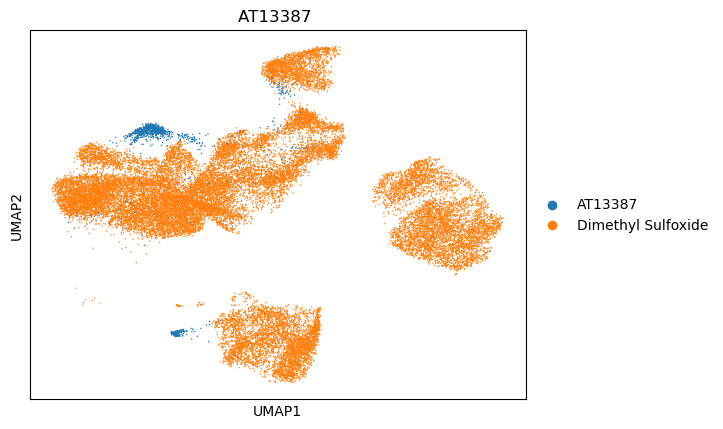

In [73]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(["AT13387"] + ["Dimethyl Sulfoxide"])], color='sm_name', title="AT13387 ")

/Users/arturszalata/miniconda3/envs/open-problems-23-sc-perturbation-prediction/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


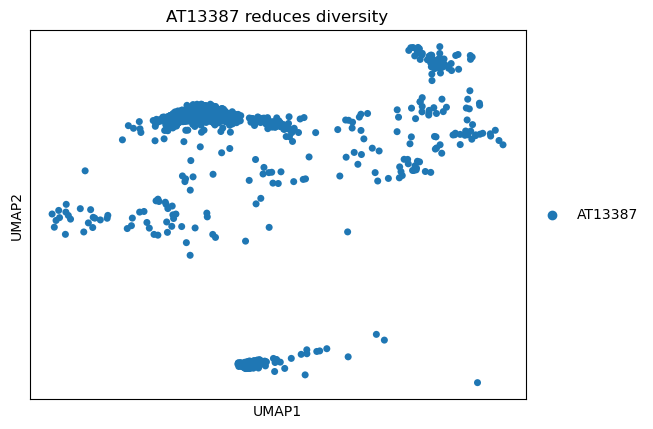

In [74]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(["AT13387"])], color='sm_name', title="AT13387 reduces diversity")

/Users/arturszalata/miniconda3/envs/open-problems-23-sc-perturbation-prediction/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


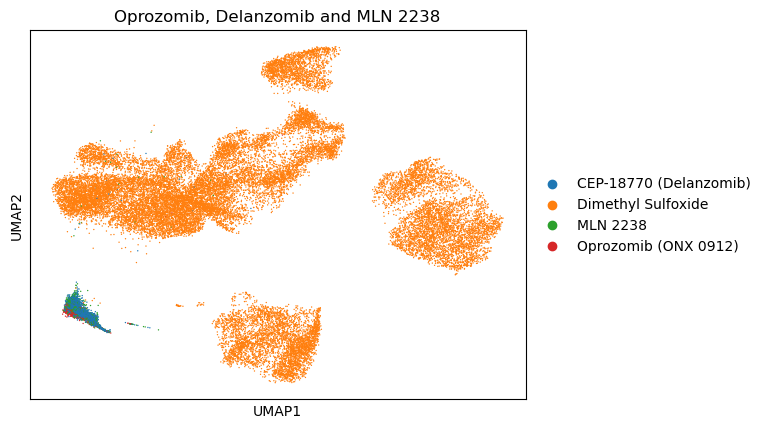

In [102]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(sc_counts.obs.sm_name.unique().tolist()[10:11] + ["Dimethyl Sulfoxide", "MLN 2238", "CEP-18770 (Delanzomib)"])], color='sm_name', title="Oprozomib, Delanzomib and MLN 2238")

/Users/arturszalata/miniconda3/envs/open-problems-23-sc-perturbation-prediction/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


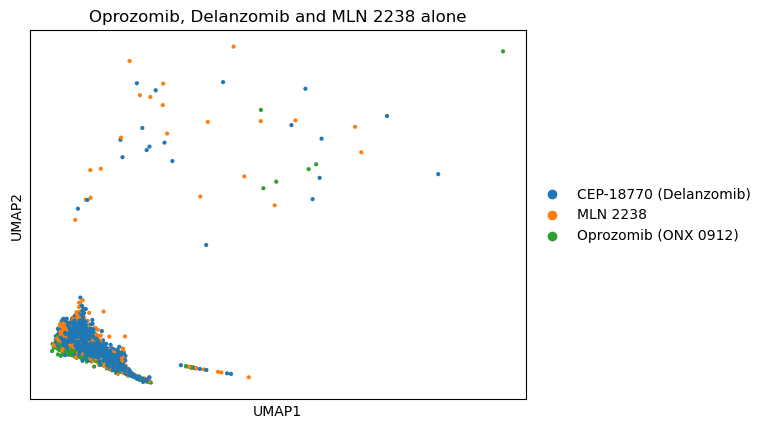

In [101]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(sc_counts.obs.sm_name.unique().tolist()[10:11] + ["MLN 2238", "CEP-18770 (Delanzomib)"])], color='sm_name', title="Oprozomib, Delanzomib and MLN 2238 alone")

/Users/arturszalata/miniconda3/envs/open-problems-23-sc-perturbation-prediction/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


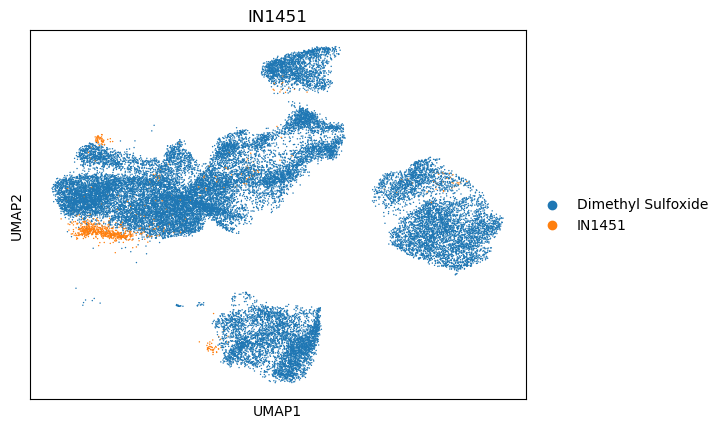

In [111]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(['IN1451', 'Dimethyl Sulfoxide'])], color='sm_name', title="IN1451")

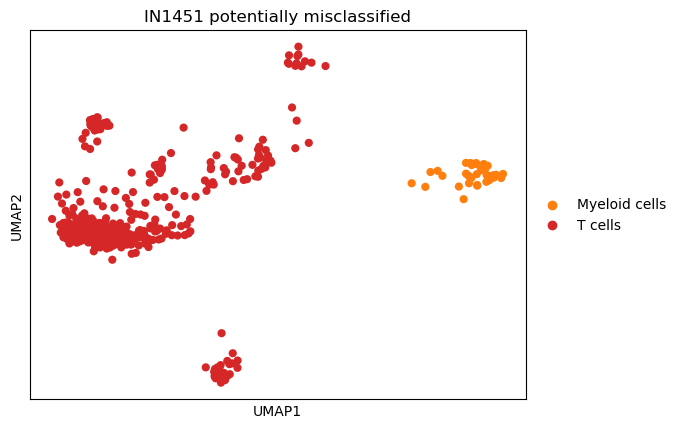

In [112]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(['IN1451'])], color='cell_type', title="IN1451 potentially misclassified")

In [4]:
import celltypist
from celltypist import models

In [173]:
models.download_models()

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 46
📂 Storing models in /Users/arturszalata/.celltypist/data/models
💾 Downloading model [1/46]: Immune_All_Low.pkl
💾 Downloading model [2/46]: Immune_All_High.pkl
💾 Downloading model [3/46]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/46]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/46]: Adult_Human_Skin.pkl
💾 Downloading model [6/46]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/46]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/46]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/46]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/46]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/46]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/46]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/46]: Cells_Adult_Breast.pkl
💾 Downloading model [14/46]: Cells_Fetal_Lung.pkl
💾 Downloading model [15/46]: Cells_Human_Tonsi

In [5]:
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [196]:
in1451_celltypes = sc_counts[sc_counts.obs.sm_name.isin(['IN1451'])].copy()
predictions = celltypist.annotate(in1451_celltypes, model = model, majority_voting = True)
in1451_celltypes.obs["celltypist_celltype"] = predictions.predicted_labels.predicted_labels

🔬 Input data has 863 cells and 18110 genes
🔗 Matching reference genes in the model
🧬 5193 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [208]:
def map_cell_types(label):
    mapping = {
        'T cells': 'T cells',
        'B cells': 'B cells',
        'ILC': 'NK cells',
        'DC': 'Myeloid cells',
        'Macrophages': 'Myeloid cells'
    }
    return mapping.get(label, label)  # Default to original label if not found in mapping

# Apply the mapping to the DataFrame
in1451_celltypes.obs['celltypist_celltype'] = in1451_celltypes.obs['celltypist_celltype'].apply(map_cell_types)

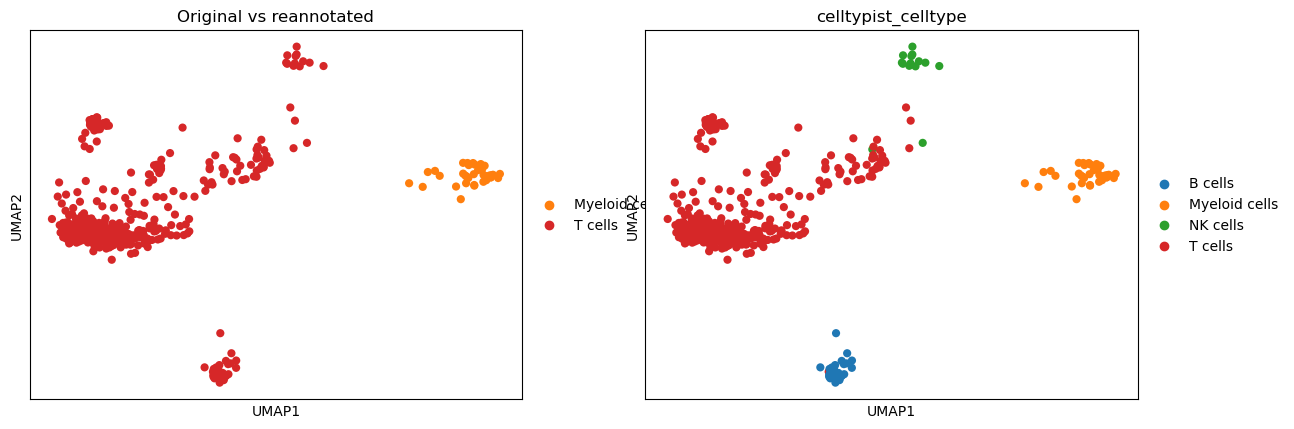

In [212]:
sc.pl.umap(in1451_celltypes, color=['cell_type', "celltypist_celltype"], title="Original vs reannotated")

In [ ]:
['Ganetespib (STA-9090)', 'Proscillaridin A;Proscillaridin-A', 'AT13387'] # MOA not clear

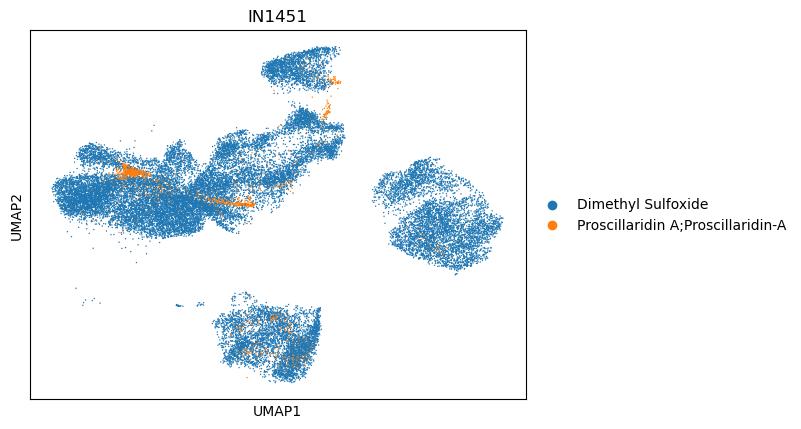

In [224]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(['Proscillaridin A;Proscillaridin-A', 'Dimethyl Sulfoxide'])], color='sm_name', title="IN1451")

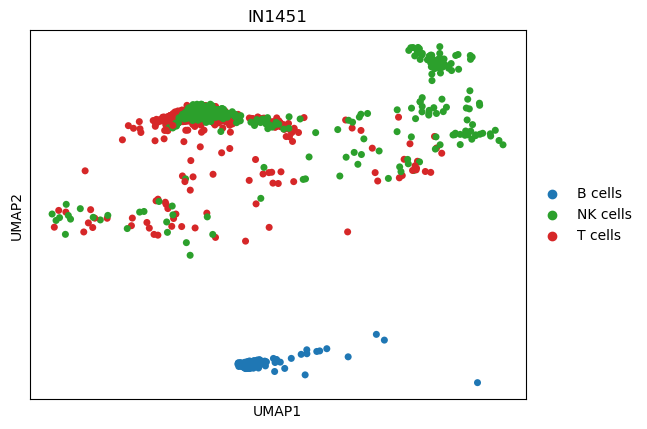

In [229]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name.isin(['AT13387'])], color='cell_type', title="IN1451")

In [230]:
unii_celltypes = sc_counts[sc_counts.obs.sm_name.isin(['AT13387'])].copy()
predictions = celltypist.annotate(unii_celltypes, model = model, majority_voting = True)
unii_celltypes.obs["celltypist_celltype"] = predictions.predicted_labels.predicted_labels

🔬 Input data has 1174 cells and 18110 genes
🔗 Matching reference genes in the model
🧬 5193 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


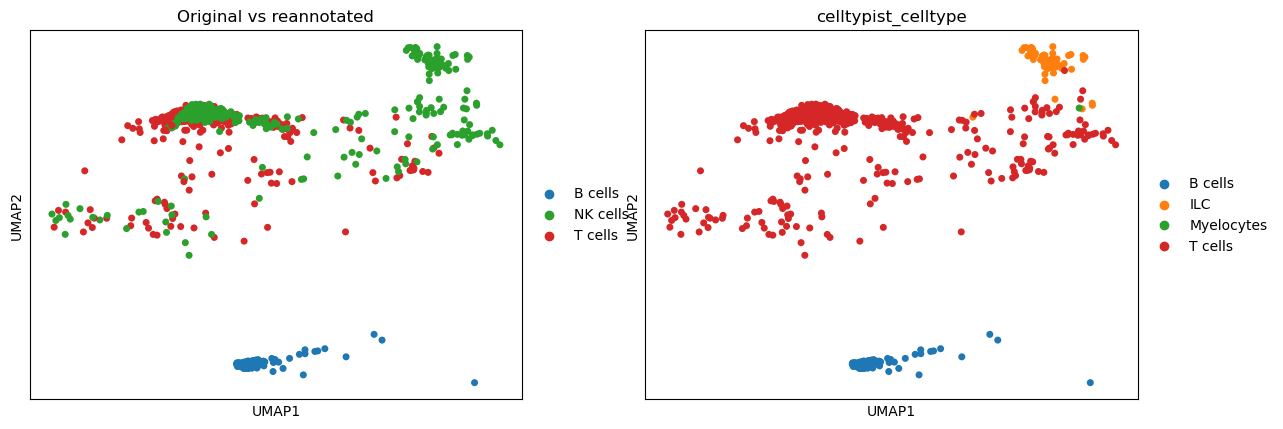

In [231]:
sc.pl.umap(unii_celltypes, color=['cell_type', "celltypist_celltype"], title="Original vs reannotated")

In [ ]:
# run celltypist on the whole dataset
predictions = celltypist.annotate(sc_counts, model = model, majority_voting = True)
sc_counts.obs["celltypist_celltype"] = predictions.predicted_labels.predicted_labels

🔬 Input data has 290957 cells and 18110 genes
🔗 Matching reference genes in the model
🧬 5193 features used for prediction
⚖️ Scaling input data


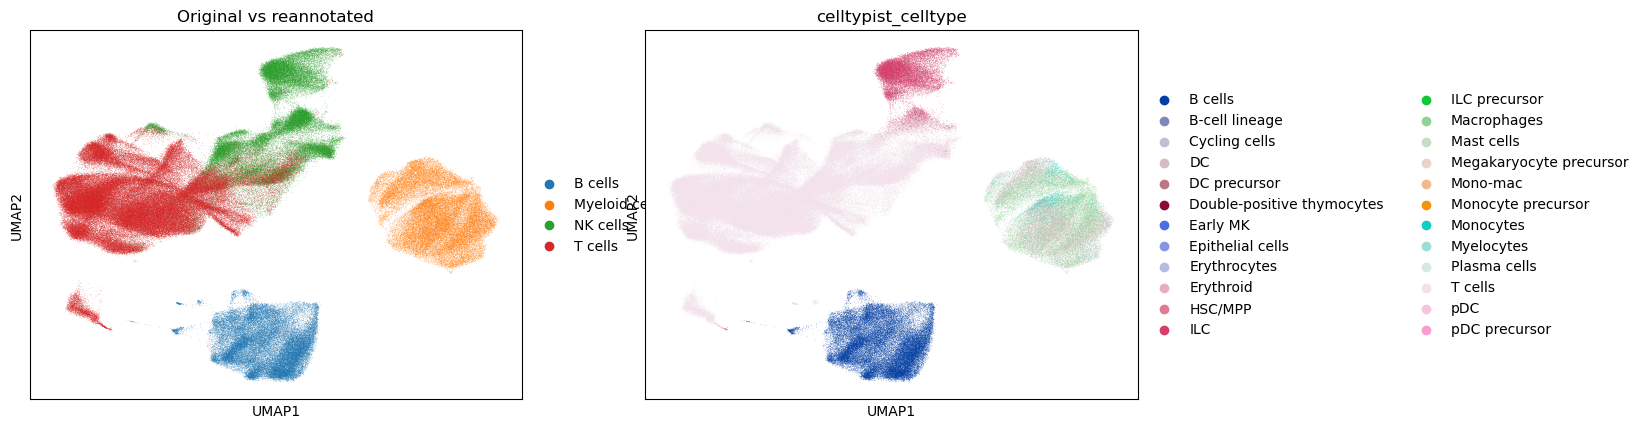

In [233]:
sc.pl.umap(sc_counts, color=['cell_type', "celltypist_celltype"], title="Original vs reannotated")

In [238]:
sc_counts.obs.celltypist_celltype.unique().tolist()

['B cells',
 'T cells',
 'Macrophages',
 'ILC',
 'DC',
 'Monocytes',
 'Cycling cells',
 'Plasma cells',
 'Double-positive thymocytes',
 'Epithelial cells',
 'Mono-mac',
 'Myelocytes',
 'pDC',
 'HSC/MPP',
 'pDC precursor',
 'Monocyte precursor',
 'Early MK',
 'Erythrocytes',
 'Erythroid',
 'ILC precursor',
 'Mast cells',
 'DC precursor',
 'Megakaryocyte precursor',
 'B-cell lineage']

In [280]:
sc_counts.obs["is_in"] = sc_counts.obs.celltypist_celltype.isin(['HSC/MPP'])

In [ ]:
sc.pl.umap(sc_counts, color=["is_in"], title="reannotated")

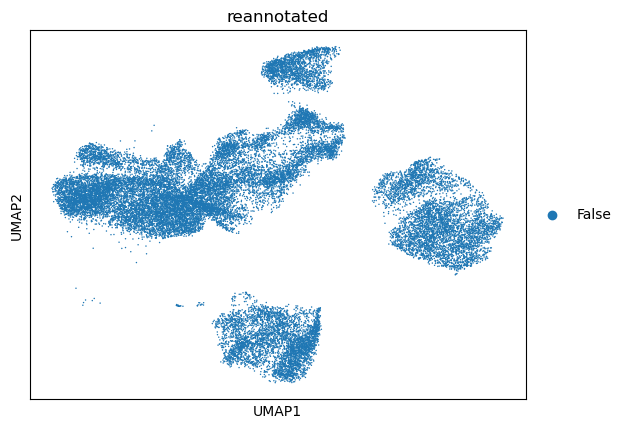

In [279]:
sc.pl.umap(sc_counts[sc_counts.obs.sm_name == "Dimethyl Sulfoxide"], color=["is_in"], title="reannotated")

In [242]:
from collections import defaultdict

In [244]:
mapping = {
    'B cells': 'B cells',
    'Plasma cells': 'B cells',
    'B-cell lineage': 'B cells',
    'T cells': 'T cells',
    'Double-positive thymocytes': 'T cells',
    'Macrophages': 'Myeloid cells',
    'DC': 'Myeloid cells',
    'Monocytes': 'Myeloid cells',
    'Mono-mac': 'Myeloid cells',
    'Myelocytes': 'Myeloid cells',
    'pDC': 'Myeloid cells',
    'Monocyte precursor': 'Myeloid cells',
    'Early MK': 'Myeloid cells',
    'Erythrocytes': 'Myeloid cells',
    'Erythroid': 'Myeloid cells',
    'DC precursor': 'Myeloid cells',
    'Megakaryocyte precursor': 'Myeloid cells',
    'ILC': 'NK cells',
    'ILC precursor': 'NK cells',
    # Additional or exceptional mappings
    'HSC/MPP': 'Stem cells',  # You might categorize differently or exclude
    'pDC precursor': 'Myeloid cells',
    'Cycling cells': 'Other',  # or based on additional context
    'Epithelial cells': 'Non-immune',  # not part of the immune classification
    'Mast cells': 'Other immune cells',  # Specific category as they are unique
}

In [245]:
reverse_mapping = defaultdict(list)

# Populate the reverse mapping dictionary
for cell_type, category in mapping.items():
    reverse_mapping[category].append(cell_type)

# Convert defaultdict to a regular dictionary for easier use later
reverse_mapping = dict(reverse_mapping)

# Example of what is in the reverse mapping
for category, types in reverse_mapping.items():
    print(f"{category}: {types}")

B cells: ['B cells', 'Plasma cells', 'B-cell lineage']
T cells: ['T cells', 'Double-positive thymocytes']
Myeloid cells: ['Macrophages', 'DC', 'Monocytes', 'Mono-mac', 'Myelocytes', 'pDC', 'Monocyte precursor', 'Early MK', 'Erythrocytes', 'Erythroid', 'DC precursor', 'Megakaryocyte precursor', 'pDC precursor']
NK cells: ['ILC', 'ILC precursor']
Stem cells: ['HSC/MPP']
Other: ['Cycling cells']
Non-immune: ['Epithelial cells']
Other immune cells: ['Mast cells']


In [240]:
def map_cell_types(cell_type):
    return mapping.get(cell_type, 'Other')  # Default to 'Other' if not listed

In [239]:
sc_counts.obs.celltypist_celltype.value_counts()

celltypist_celltype
T cells                       179717
B cells                        45533
ILC                            21987
Macrophages                    20639
DC                             19309
Monocytes                       3309
Plasma cells                     227
Myelocytes                        69
Cycling cells                     64
HSC/MPP                           27
Mono-mac                          25
Erythroid                         12
Early MK                          11
Epithelial cells                   5
Double-positive thymocytes         5
pDC                                4
Monocyte precursor                 4
Mast cells                         3
Erythrocytes                       2
ILC precursor                      1
Megakaryocyte precursor            1
B-cell lineage                     1
DC precursor                       1
pDC precursor                      1
Name: count, dtype: int64